# Coefficient of Partial Determination (CPD) analysis

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import cm
from matplotlib import colors as mpl_colors
import matplotlib.pyplot as plt
import vr2p
import os
from sklearn.linear_model import LinearRegression
import pandas as pd
from tqdm.notebook import tqdm
from vr2p import styles
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator
plt.style.use(styles('publication-tight'))

## CPD analysis for all Cue Set A animals

In [2]:
def _CPD(X,y):
    """Helper function to evaluate coefficient of partial determination for licking strategy.
    
        Inspired by Samborska et al., 2022 (https://github.com/veronikasamborska1994/notebooks_paper/blob/main/functions/helper_functions.py)
        Arguments:
        X {numpy array}         -- Behavioral kernels to evaluate (size: number of kernels x (concatenated positional bins for both trial types)
        y {numpy array}         -- Measured behavioral pattern as percentage of licks in each bin (size:concatenated positional bins for both trial types)

    Returns:
        numpy array             -- size: number of kernels. Percentage decrease in error with the additional regressor
                                (The decrease in Sum Squared Error (SSE) after removal of each kernel 
                                divided by the full SSE using all kernels)
    """
    ols = LinearRegression(copy_X = True,fit_intercept= False)
    ols.fit(X,y)
    # get r squared
    r2 = ols.score(X,y)
    sse = np.sum((ols.predict(X) - y)**2, axis=0)
    cpd = np.zeros([1,X.shape[1]])
    for i in range(X.shape[1]):
        X_i = np.delete(X,i,axis=1)
        ols.fit(X_i,y)
        sse_X_i = np.sum((ols.predict(X_i) - y)**2, axis=0)
        if len(np.where(sse_X_i== 0)[0]) > 0:
            cpd[:,i] = np.NaN
        else:
            cpd[:,i]=(sse_X_i-sse)/sse_X_i
    return cpd[0], r2
def create_kernel(ranges,bin_size=5):
    """ Create behavioral lick kernel based on trial type positional ranges
    
        Arguments:
        ranges {dictionary}    -- Dictionary with ranges must contains keyword (near and far)
                                    each entry is nested list with positional ranges in cm (min-max)
        bin_size (int)         -- Size of positional bins in cm (Optional: default = 5)
        Returns: 
            numpy array        -- normalized (for each individual trial type) behavioral kernel 
                                  (size: concatenated number of positional bins for both trial types)
    
    """
    assert ('near' in ranges) & ('far' in ranges), 'ranges dictionary did not contain near and far keys'
    bool_position = [np.arange(0,230,bin_size) for i in range(2)]
    for i_type, trial_type in enumerate(['near','far']):
        c_bool = bool_position[i_type]
        for c_range in ranges[trial_type]:
            c_bool[(c_bool>=c_range[0]) & (c_bool<c_range[1])]=1000 # bins are left inclusive. (there is no 230)
        # get percentages.
        c_bool = (c_bool==1000).astype(float)
        c_bool = c_bool/c_bool.sum()
        # assert that kernel sums to 1.
        assert np.round(c_bool.sum(),2)==1, f'kernel did not sum to 1 but {c_bool.sum()}'
        bool_position[i_type] = c_bool
    # join.
    bool_position = np.expand_dims(np.hstack(bool_position),axis=1)

    return bool_position

## Generate behavior basis functions

```
markers = [{'name':'Initial','position': [0,30]},
            {'name':'Indicator','position': [60,100]},
            {'name':'R1','position': [130,150]},
            {'name':'R2','position': [180,200]},]
```

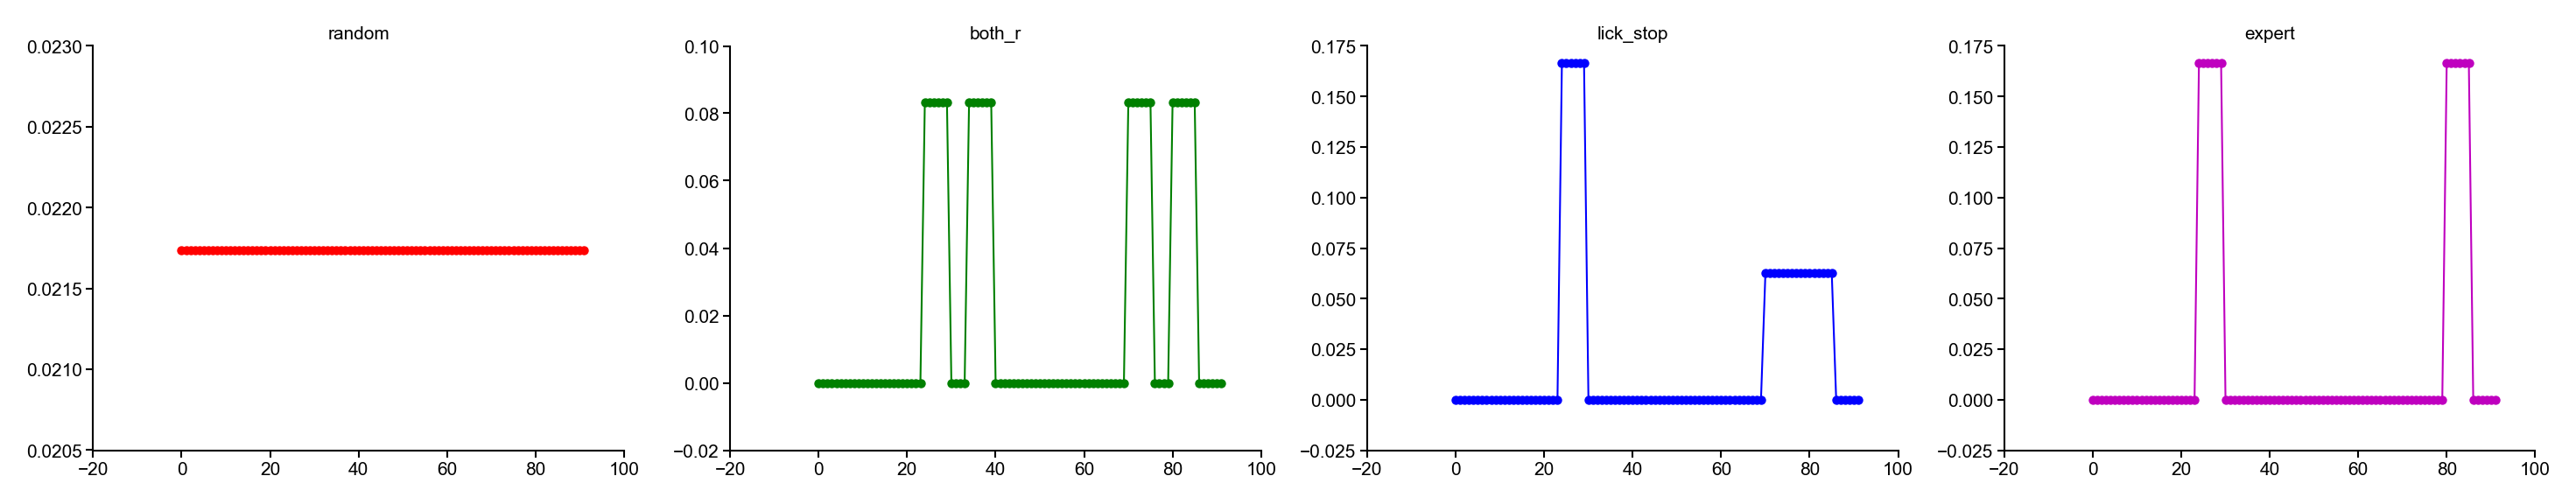

In [3]:
# spatial bin
bin_size = 5

# random
random = create_kernel({'near':[[0,230]],'far': [[0,230]]}, bin_size)
# Reward only
both_r = create_kernel({'near':[[120,150],[170,200]],'far': [[120,150],[170,200]]},bin_size)# assign near trial values, starting 10cm before the Reward cue.
#both_r = create_kernel({'near':[[120,200]],'far': [[120,200]]},bin_size)# assign near trial values, starting 10cm before the Reward cue. 
# Lick-Stop
lick_stop = create_kernel({'near':[[120,150]],'far': [[120,200]]}, bin_size)# continous licking from R1 to R2 kernel seems to work the best
# Expert
expert = create_kernel({'near':[[120,150]],'far': [[170,200]]}, bin_size)# assign near trial values, starting 10cm before the Reward cue. 
# Combine regressors for regression analysis
kernel_names = ['random','both_r','lick_stop','expert']
kernels = np.hstack((random,both_r,lick_stop,expert))

## plot the kernels
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), dpi=300)
colors= ['r','g','b','m']
for i_key, key in enumerate(kernel_names):
    ax = axes[i_key]
    ax.plot(kernels[:,i_key],colors[i_key])
    ax.set_title(key)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [4]:
# Parameters
animals = ['A4','A5','A7','B2','B3','B4','B5','C1','D1','F1', 'F5']
remove_licks_on_place = True # these can both be true.
remove_licks_on_time = False
remove_licks_after_reward_sec = 4 # in seconds.
remove_licks_after_reward_cm = 10 # in cm
period_number = 2 # break up each session into this many periods of equal time.
time_range = [0,40] # time period to break into seperate periods

# intialize
final_matrix = np.zeros((len(animals),20)) # CPD matrix, (size: number of animals x max number of sessions).

# go through animals.
results = []
for i_animal,animal in tqdm(enumerate(animals),desc='animals',total=len(animals)):
    # get animal data
    data = vr2p.ExperimentData(f'gs://linear-2ac/Set A/Tyche-{animal}-SetA.zarr')
    # go through sessions.
    cum_period = 0
    for i_session, vr in enumerate(data.vr):
        lick = vr.lick.copy()
        trial = vr.trial.copy()
        # select needed info
        lick=lick[['time','position','trial_number']]
        # remove licks outside of trials.
        lick =lick[lick['trial_number'].isnull()==False]
        lick['trial_number'] = lick['trial_number'].astype('int')
        # remove licks.
        # remove based on proximity to reward
        reward = vr.reward.copy()
        if remove_licks_on_place:
            # Go through reward.
            filter_ind = [] # stores lick indices to remove
            for index, row in reward.iterrows():
                is_trial = (lick.trial_number==row.trial_number)
                is_in_pos = (lick.position.between(row.position,row.position+remove_licks_after_reward_cm))
                is_in_time = (lick.time.between(row.time,row.time+pd.to_timedelta(remove_licks_after_reward_sec,unit='s')))
                if remove_licks_on_time:
                    filter_ind.append(lick.loc[is_trial & is_in_pos & is_in_time].index.to_numpy())
                else:
                    filter_ind.append(lick.loc[is_trial & is_in_pos].index.to_numpy())    
            lick = lick.drop(np.hstack(filter_ind))
        # remove based on time
        else:
            for index, row in reward.iterrows():
                lick = lick.loc[lick.time.between(row.time,row.time + pd.to_timedelta(remove_licks_after_reward_sec, unit="s"))==False]
        lick=lick[['position','trial_number']]
        # add period info.
        trial['session_period'] = None
        delta_time = (time_range[1]-time_range[0])/period_number
        time_start = time_range[0]
        for i in range(period_number):
            trial.loc[trial.time_start.between(pd.Timedelta(time_start,'min'),pd.Timedelta(time_start+delta_time,'min')),'session_period'] = i
            time_start+=delta_time
        #  select data.
        trial = trial[['trial_number','reward_id','session_period','status','is_guided']]
        # adjust trial type (near / far)
        trial['reward_id'] = trial['reward_id'].replace({1:'near',2:'far'})
        trial = trial.rename(columns={'reward_id': 'trial_type'})
        # merge trial information
        lick = pd.merge(lick, trial, on='trial_number', how='inner')
        # filter on status (no NO_RESPONSE)
        lick = lick[lick['status'] != 'NO_RESPONSE'].drop(columns='status')
        # filter on position < 230
        lick = lick[lick['position'] <230]
        # add spatial bin info.
        spatial_bins = np.arange(0, 230+bin_size, bin_size)
        lick['bin'] = pd.cut(lick['position'],spatial_bins,labels = np.arange(0,spatial_bins.shape[0]-1),right=False).astype(int)
        assert lick['bin'].max()<=((230/bin_size)-1),'Bin positions extended outside of expected range'
        
        # go by session period.
        for period in range(period_number):
            lick_behavior = []
            # go by trial type and normalize seperately.
            num_trials = {}
            for trial_type in ['near','far']:
                period_licks = lick.loc[(lick.session_period==period) & (lick.trial_type==trial_type),
                                        ['trial_number','bin']]
                # fill out observed behavior data in numpy array.
                period_lick_array = np.zeros((period_licks.trial_number.max()+1, int((230/bin_size))))
                for index, row in period_licks.iterrows():
                    period_lick_array[row.trial_number,row.bin]+=1
                # get total licks of each trial.
                total_trial_licks= period_lick_array.sum(axis=1)
                # remove zero rows (no licks).
                period_lick_array = period_lick_array[total_trial_licks>0,:]
                total_trial_licks = total_trial_licks[total_trial_licks>0]
                # get normalized licks in each bin.
                period_lick_array =  (period_lick_array.T / total_trial_licks).T
                # check that rows sum to 1 (properly normalized)
                assert all(np.round(period_lick_array.sum(axis=1),2)==1), 'normalization for licks failed'
                # store number of trials
                num_trials[trial_type] = period_lick_array.shape[0]
                # average all trials.
                avg_period_lick = period_lick_array.mean(axis=0)
                assert np.round(avg_period_lick.sum(),2)==1, 'normalization for averaged licks failed'
                # store.
                lick_behavior.append(avg_period_lick)
            # check if there was enough data present.
            # concatenate licking for both trial types (similar to kernels)                
            lick_behavior = np.expand_dims(np.hstack(lick_behavior),axis=1)
            assert lick_behavior.shape==expert.shape, 'Calculated behavior vector did not match expected size'
            # calculate CPD.
            cpd_result, r2 = _CPD(kernels, lick_behavior)
            # store.
            temp = {'animal':animal,'cum_period':cum_period,'session':i_session,'r2':r2, 'max_strategy': kernel_names[cpd_result.argmax()],
                       'max_value': max(cpd_result),'is_guided':lick.loc[(lick.session_period==period),'is_guided'].median()==1}
            for i_kernel, kernel_name in enumerate(kernel_names):
                temp[f'{kernel_name}'] = cpd_result[i_kernel]
            # add trial number info.
            for trial_type in ['near','far']:
                temp[f'n_{trial_type}'] = num_trials[trial_type]
            results.append(temp)
            # increase cumulative period
            cum_period+=1
results = pd.DataFrame(results)
display(results)

animals:   0%|          | 0/11 [00:00<?, ?it/s]

,animal,cum_period,session,r2,max_strategy,max_value,is_guided,random,both_r,lick_stop,expert,n_near,n_far
0,A4,0,0,0.065246,random,0.289957,True,0.289957,0.021622,0.007330,0.017374,21,13
1,A4,1,0,0.038457,random,0.134097,True,0.134097,0.004383,0.004977,0.033663,9,10
2,A4,2,1,0.022202,random,0.188560,True,0.188560,0.000339,0.015054,0.020565,18,18
3,A4,3,1,0.277679,random,0.136141,True,0.136141,0.133429,0.085050,0.134463,13,16
4,A4,4,2,0.443081,both_r,0.332935,False,0.107579,0.332935,0.052260,0.169530,13,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,F5,7,3,0.505350,expert,0.252292,False,0.002407,0.000011,0.000084,0.252292,25,20
190,F5,8,4,0.415795,expert,0.178395,False,0.001516,0.000167,0.001335,0.178395,59,60
191,F5,9,4,0.461510,expert,0.216061,False,0.024628,0.003234,0.000523,0.216061,30,31
192,F5,10,5,0.411352,expert,0.133840,False,0.001727,0.001320,0.016170,0.133840,45,55


# Explained variance (text)

In [7]:
# get average R2 across all sessions for each individual animal.
results_avg = results[['animal','r2']].groupby(['animal']).mean()
print(f"Explained variance (R2) across all sessions: {results_avg['r2'].mean()*100:.2f} +- {results_avg['r2'].std()*100:.2f} %")

Explained variance (R2) across all sessions: 36.50 +- 5.91 %


# All animals all sessions (non normalized)

    animal  cum_period max_strategy  session  max_value  n_near  n_far
0       A4           0            0        0   0.289957      21     13
1       A4           1            0        0   0.134097       9     10
2       A4           2            0        1   0.188560      18     18
3       A4           3            0        1   0.136141      13     16
4       A4           4            1        2   0.332935      13     10
..     ...         ...          ...      ...        ...     ...    ...
189     F5           7            3        3   0.252292      25     20
190     F5           8            3        4   0.178395      59     60
191     F5           9            3        4   0.216061      30     31
192     F5          10            3        5   0.133840      45     55
193     F5          11            3        5   0.221555      28     21

[194 rows x 7 columns]
[ 4  5  5  5  6  6  8  9 12 12 14]
['B4' 'A5' 'F1' 'F5' 'B2' 'B5' 'A7' 'A4' 'C1' 'D1' 'B3']


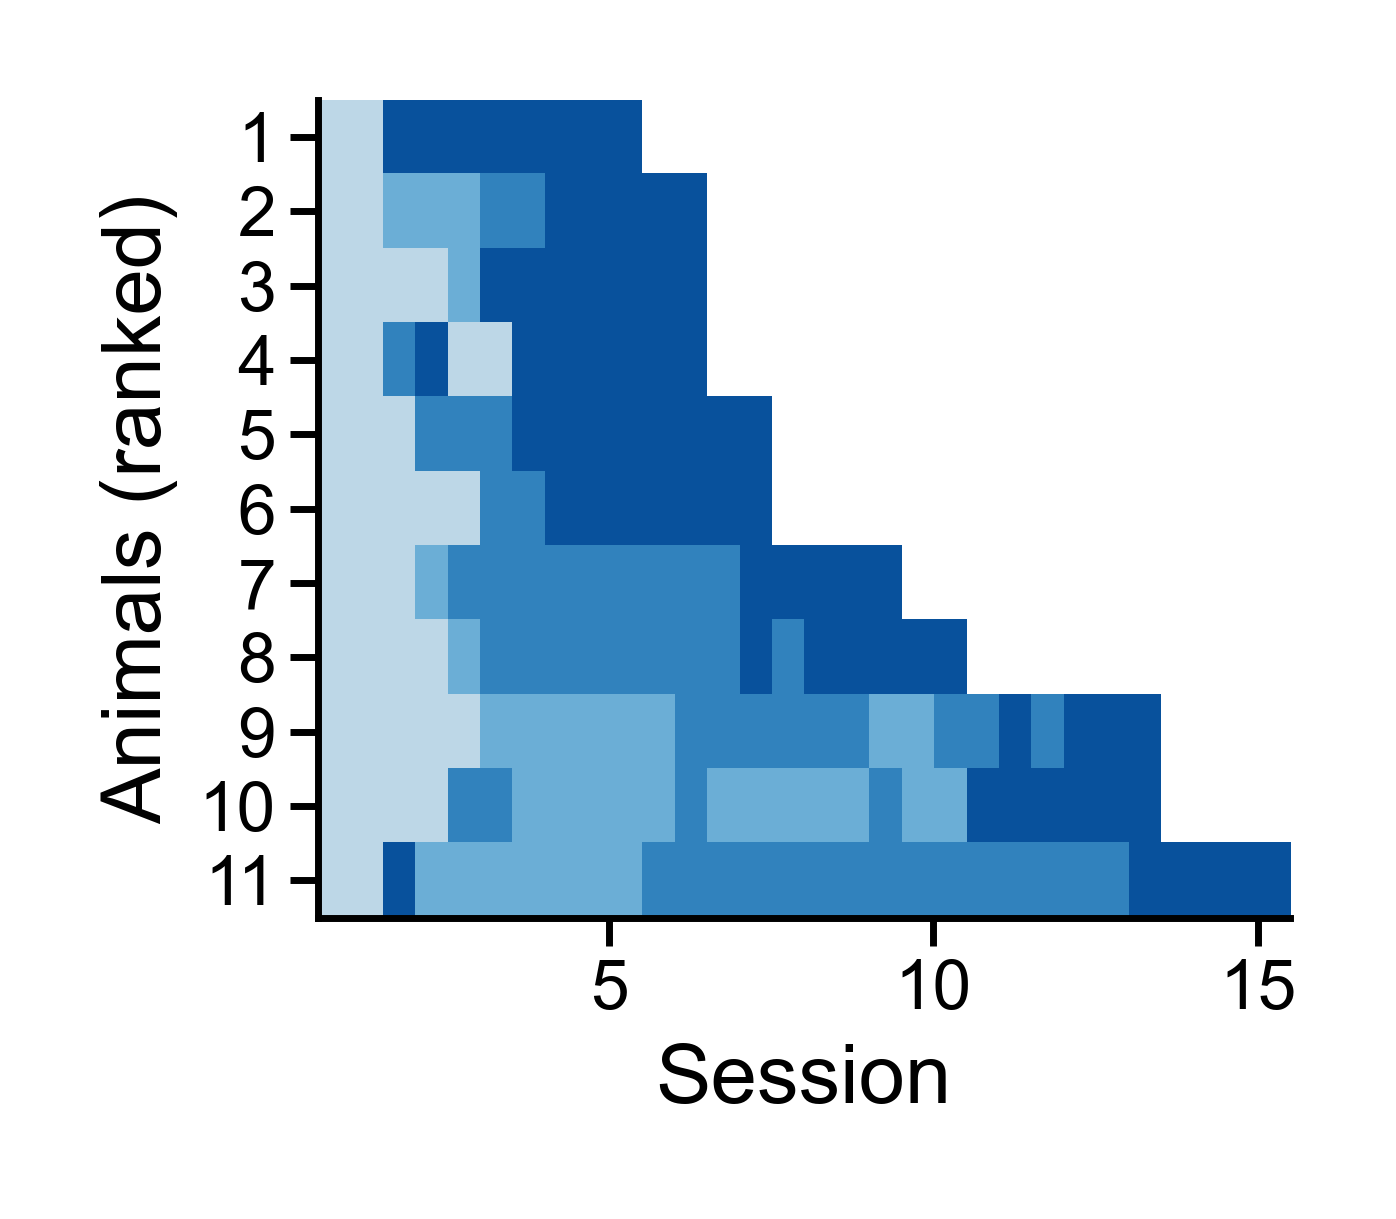

In [ ]:
remove_low_trial_periods = False
# build heatmap.
heatmap = results[['animal','cum_period','max_strategy','session','max_value','n_near','n_far']].copy()
for i_kernel, kernel in enumerate(kernel_names):
    heatmap.loc[heatmap.max_strategy==kernel,'max_strategy']=i_kernel
print(heatmap)
    
# sort animals by max sessions
max_sessions = np.array([results.loc[results.animal==animal,'session'].max() for animal in animals])
print(np.sort(max_sessions))
print(np.array(animals)[np.argsort(max_sessions)])
for i_animal, animal in enumerate(np.array(animals)[np.argsort(max_sessions)]):
    heatmap.loc[heatmap.animal==animal,'animal']=i_animal
heatmap = heatmap.astype({'max_strategy':'int','animal':'int'})
heatmap.max_strategy+=1
#heatmap.loc[heatmap.max_value<=0.05,'max_strategy']=0
if remove_low_trial_periods:
    heatmap.loc[(heatmap.n_near + heatmap.n_far)<=10,'max_strategy']=0
im = np.empty((len(animals),results.cum_period.max()+1))
im[heatmap.animal,heatmap.cum_period]= heatmap.max_strategy
# plot
axs = plt.figure(figsize=(32.5/25.4 ,28/25.4),dpi=1000,layout="constrained").subplot_mosaic(
    [
        ['animals'],
    ],
    empty_sentinel="BLANK",
    # set the height ratios between the rows
    height_ratios=[1,],
    # set the width ratios between the columns
    width_ratios=[1],
)

color_names = ['white', '#bdd7e7', '#6baed6', '#3182bd', '#08519c'] # sequence blue

cc = mpl_colors.ListedColormap(color_names)
ax = axs['animals']
ax.set_xlabel('Session')
ax.set_yticks(range(1,len(animals)+1))
ax.set_yticklabels(np.arange(1,len(animals)+1)[::-1])
ax.set_ylabel('Animals (ranked)')
# show heatmap
ax.imshow(im, extent=(0.5,heatmap.session.max()+1.5,0.5,heatmap.animal.max()+1.5),cmap=cc, aspect='auto')
# legend
#ax = axs['legend']
#ax.axis('off')
#y_pos =0.975
#for i_kernel, kernel_name in enumerate(['Random','Both','Lick Stop','Expert']):
#    ax.text(-0.1,y_pos,kernel_name,color = color_names[i_kernel+1],va='top')
#    y_pos-= 0.1

# Single animal Strategy plots

B2
14


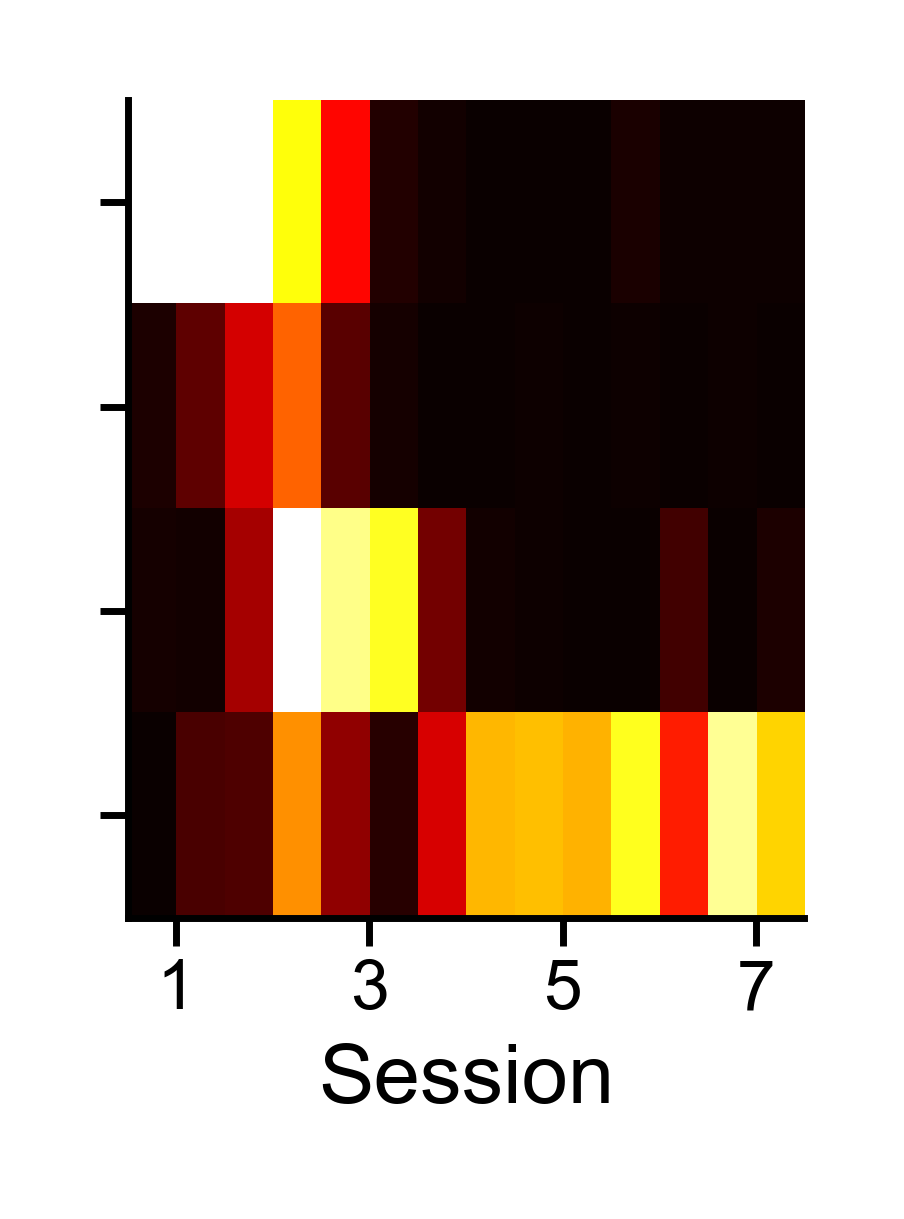

In [ ]:
animal = animals[3]
print(animal)
c_result = results.loc[results.animal==animal]
x = [  (x/2) +0.75 for x in c_result.cum_period]
# create heatmap.
im = np.empty((4,len(x)))
for i_key, key in enumerate(['random','both_r','lick_stop','expert']):
    im[i_key,:] = c_result[key]

# plot
axs = plt.figure(figsize=(20/25.4,28/25.4),dpi=1000,layout="constrained").subplot_mosaic(
    [
        ['plot'],
    ],
    empty_sentinel="BLANK",
    # set the height ratios between the rows
    height_ratios=[1],
    # set the width ratios between the columns
    width_ratios=[1],
)
ax = axs['plot']
ax.set_xlabel('Session')

ax.set_yticks(range(1,5))
ax.set_yticklabels(['Expert','Lick-stop','Both Rew.','Random'])
ax.set_yticklabels([])
#ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax.xaxis.set_major_locator(MultipleLocator(base=2))
ax.set_xticks(range(1,9,2))
# show heatmap
print(im.shape[1])
ax.imshow(im, extent=(0.5,round(max(x))+0.5,0.5,im.shape[0]+.5),cmap='hot', aspect='auto',vmin=0,vmax=0.3)